In [24]:
import mlflow
import glob
import pandas as pd
import os
import numpy as np
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from reject_anomalies import pred_baseon_threshold,make_use_reject_anomalies
from Data_preprocessing_method import apply_PCA
from Feature_engineer import remove_unwanted_col_autoencoder,feature_engineer_steps
from result_display import show_result
from AutoEncoder_util import convert_type, transform_data, mad_score
import mlflow.tensorflow

In [25]:
def search_newest_model(experiment_name,run_name):
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment:
        experiment_id = experiment.experiment_id
        
    else:
        raise ValueError(f"Experiment named {experiment_name} not found")



    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    #print(runs['tags.mlflow.runName'])
    filtered_runs = runs[(runs['tags.mlflow.runName'] == run_name) & (runs.status == 'FINISHED') ]

    if filtered_runs.empty:
        raise ValueError(f"No runs with name {run_name} found in experiment {experiment_name}")
    return filtered_runs.iloc[0]

In [26]:
def update_model(model_information,rejected_list_path):
    anomalies = pd.read_csv(rejected_list_path)
    experiment_ids = model_information['experiment_id']
    client = MlflowClient()
    runs = client.search_runs(experiment_ids=experiment_ids)
    sensitivity = 0.005
    if runs:
        run_id = model_information['run_id']
        current_run = client.get_run(run_id)
        artifact_path = model_information['artifact_uri']       
        model_uri = f"{artifact_path}/mlruns"
        model = mlflow.tensorflow.load_model(model_uri)
        THRESHOLD = model_information['params.threshold']
        print(model)
        anomalies = convert_type(anomalies)
        anomalies = transform_data(anomalies)
        anomalies = apply_PCA(anomalies,7)
        model.fit(anomalies, anomalies, epochs=1, batch_size=8)
        
        with mlflow.start_run(experiment_id=experiment_ids,run_name=model_information['tags.mlflow.runName']) as run:
        # Log the parameters used for the model fit
            mlflow.log_param("batch_size", "256")
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("EPOCHS", 100)
            mlflow.log_param("activation_function", "relu")
            mlflow.log_param("num_layers", 9)
            mlflow.log_param("threshold", THRESHOLD)
            mlflow.log_param("PCA_sample", 7)
            mlflow.log_artifact(local_path = "Feature_engineer.py")

            # Log an instance of the trained model for later use
            model_info = mlflow.tensorflow.log_model(model, artifact_path="mlruns", registered_model_name="AutoEncoder_PCA")

    else:
        print("No runs found.")

## Demo of effect of retrain on reject anomalies

In [27]:
transactions_df = pd.read_csv("data/user_demo_data.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')
test_X,test_y = feature_engineer_steps(join_customer)
test_X = remove_unwanted_col_autoencoder(test_X)

test_X = convert_type(test_X)
test_y = convert_type(test_y)
test_X_transformed = transform_data(test_X)
test_X_transformed_PCA = apply_PCA(test_X_transformed,7)

In [28]:
model_info = search_newest_model("AutoEncoder_model","AutoEncoder")
print(model_info)
artifact_path = model_info['artifact_uri']       
model_uri = f"{artifact_path}/mlruns"
model = mlflow.tensorflow.load_model(model_uri)
reconstructions = model.predict(test_X_transformed_PCA)
mse = np.mean(np.power(test_X_transformed_PCA - reconstructions, 2), axis=1)
THRESHOLD = model_info['params.threshold']
z_scores = mad_score(mse)
outliers_PCA = z_scores > float(THRESHOLD)
print(f"Detected {np.sum(outliers_PCA):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers_PCA)/np.size(z_scores):.2%}].")
precision_PCA, recall_PCA, f1_socre_PCA = show_result(test_y,outliers_PCA,"result/confusion_matrix_autoencoder_PCA.png")
metrics_PCA = {"precision": precision_PCA, "recall": recall_PCA, "f1_socre": f1_socre_PCA,"train_threshold":THRESHOLD}

run_id                                            73ccb26c35cc43d590b3c8523c953bfc
experiment_id                                                                    1
status                                                                    FINISHED
artifact_uri                     /mnt/c/Users/Leonwu/Desktop/Master_course/COMP...
start_time                                        2024-04-16 18:32:30.588000+00:00
end_time                                          2024-04-16 18:32:34.820000+00:00
metrics.precision                                                         0.939439
metrics.recall                                                              0.8041
metrics.train_threshold                                                        1.4
metrics.f1_socre                                                          0.865401
params.num_layers                                                                9
params.batch_size                                                              256
para

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_18" is incompatible with the layer: expected axis -1 of input shape to have value 19, but received input with shape (32, 7)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 7), dtype=float32)
  • training=False
  • mask=None

In [14]:
update_model(model_info,"data/reject_anomalies_sample.csv")

<Sequential name=sequential_3, built=True>
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.3864 - loss: 1943364173824.0000


2024/04/17 04:27:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Registered model 'AutoEncoder_PCA' already exists. Creating a new version of this model...
2024/04/17 04:27:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AutoEncoder_PCA, version 37
Created version '37' of model 'AutoEncoder_PCA'.


run_id                                            b332594dfaa94dd582d029a0e3275c2f
experiment_id                                                                    1
status                                                                    FINISHED
artifact_uri                     /mnt/c/Users/Leonwu/Desktop/Master_course/COMP...
start_time                                        2024-04-16 18:27:48.287000+00:00
end_time                                          2024-04-16 18:27:52.500000+00:00
metrics.precision                                                              NaN
metrics.recall                                                                 NaN
metrics.train_threshold                                                        NaN
metrics.f1_socre                                                               NaN
params.optimizer                                                              adam
params.PCA_sample                                                                7
para

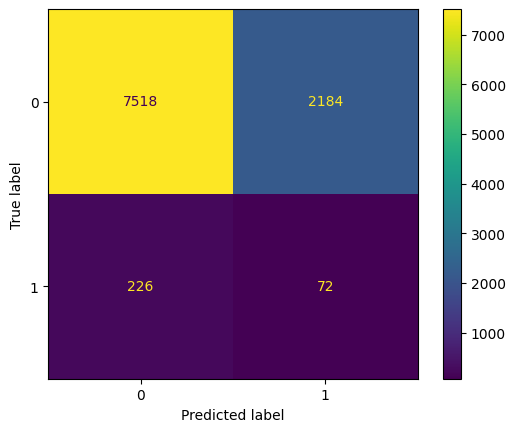

In [15]:
model_info = search_newest_model("AutoEncoder_model","AutoEncoder")
print(model_info)
artifact_path = model_info['artifact_uri']       
model_uri = f"{artifact_path}/mlruns"
model = mlflow.tensorflow.load_model(model_uri)
reconstructions = model.predict(test_X_transformed_PCA)
mse = np.mean(np.power(test_X_transformed_PCA - reconstructions, 2), axis=1)
THRESHOLD = model_info['params.threshold']
z_scores = mad_score(mse)
outliers_PCA = z_scores > float(THRESHOLD)
print(f"Detected {np.sum(outliers_PCA):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers_PCA)/np.size(z_scores):.2%}].")
precision_PCA, recall_PCA, f1_socre_PCA = show_result(test_y,outliers_PCA,"result/confusion_matrix_autoencoder_PCA.png")
metrics_PCA = {"precision": precision_PCA, "recall": recall_PCA, "f1_socre": f1_socre_PCA,"train_threshold":THRESHOLD}